## Library

In [1]:
import pandas as pd
import numpy as np
import sklearn

# Settings

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

## Visualization

In [3]:
from sklearn.tree import plot_tree
import sklearn.tree as tree
from matplotlib import pyplot as plt
import seaborn as sns

## Models

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier

from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier

## Evaluation

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc

import statsmodels.api as sm
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

## Functions

In [6]:
def plot_correlation_heatmap(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(20, 10))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.8, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"size": 20 / np.sqrt(len(corr))})

    plt.title('Correlation Heatmap')
    plt.show()

In [7]:
def clean_data(df):
    # Check for missing values
    print(df.isnull().sum())

    # Check for duplicates
    print(df.duplicated().sum())

    # Drop duplicates
    df.drop_duplicates(inplace=True)

    # Impute missing values
    # df.fillna(df.median(), inplace=True)

    # Remove outliers
    # Q1 = df.quantile(0.25)
    # Q3 = df.quantile(0.75)
    # IQR = Q3 - Q1
    # df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

In [8]:
def get_numerical_features(df):
    print(df.select_dtypes(include=[float, int]).columns)
    return df.select_dtypes(include=[float, int])

In [9]:
def select_features(df, feature_list):
    """
    Returns a DataFrame containing only the selected features from the input DataFrame.
    """
    return df[feature_list]

In [10]:
def split_X_y(df, target_col):
    # Split dataframe into X and y
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    return X, y

In [11]:
def split_data(X, y, test_size=0.2, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

In [12]:
def plot_feature_importances(model, X_train):
    # Get absolute value of coefficients
    coefs = np.abs(model.coef_)
    
    # Normalize coefficients
    coefs /= np.sum(coefs)
    
    # Sort coefficients by importance
    sorted_idx = np.argsort(coefs)
    
    # Get feature names
    feature_names = X_train.columns.values
    
    plt.figure(figsize=(8, 5))
    plt.barh(range(len(sorted_idx)), coefs[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
    # set the tick label font size and other parameters
    plt.tick_params(axis='both', which='major', labelsize=6, length=6, width=2, direction='out', pad=8)

    plt.xlabel('Normalized Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.show()

In [13]:
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled =pd.DataFrame(X_train_scaled, columns=X_train.columns)
    
    X_test_scaled = scaler.transform(X_test)
    X_test_scaled=pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    return X_train_scaled, X_test_scaled

In [39]:
def scale_features_mm(X_train, X_test):
    mm_scalar = MinMaxScaler()
    X_train_scaled_mm = mm_scalar.fit_transform(X_train)
    X_train_scaled_mm =pd.DataFrame(X_train_scaled_mm, columns=X_train.columns)
    
    X_test_scaled_mm = mm_scalar.transform(X_test)
    X_test_scaled_mm=pd.DataFrame(X_test_scaled_mm, columns=X_test.columns)
    
    return X_train_scaled_mm, X_test_scaled_mm

In [15]:
def encode_categorical_cols(df):
    # Identify categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    print("Categorical Variables:", categorical_cols)
    
    # Apply one-hot encoding
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    X_encoded = encoder.fit_transform(df[categorical_cols])
    #print(X_encoded)
    # Convert encoded features to a Pandas dataframe
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names(categorical_cols),index=df.index)

    # Drop original categorical columns and merge with encoded features
    df_encoded=df.drop(categorical_cols, axis=1)
    df_encoded = pd.concat([df_encoded, X_encoded_df], axis=1)
    return df_encoded

In [16]:
def feature_selection_pvalue_train(X_train, y_train, cols):
    # Fit the OLS model
    
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()

    ## report model summary
    print(model.summary())
    
    # Get the p-values
    pvalues = model.pvalues[1:]

    print(pvalues.index)
    # Combine the p-values with the column names
    pvalues_df = pd.DataFrame({'feature': pvalues.index, 'pvalue': pvalues})

    # Filter out the columns with p-value > 0.05
    selected_features = list(pvalues_df[pvalues_df['pvalue'] < 0.05]['feature'])

    return selected_features

In [17]:
def model_evaluation(X_train, X_test, y_train, y_test, k_fold, model_pipeline, model_names):
    i = 0
    
    for model in model_pipeline:

        model_f = model.fit(X_train, y_train)
        y_pred_test = model_f.predict(X_test)
        y_pred_train= model_f.predict(X_train)

        ave_of_cval_scores = cross_val_score(model, X_train, y_train, cv=k_fold).mean()
        std_of_cval_scores = cross_val_score(model, X_train, y_train, cv=k_fold).std()

        performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall', 'Ave of Scores', 'Std of Scores'],
                            'Train': [accuracy_score(y_train, y_pred_train),
                                        precision_score(y_train, y_pred_train),
                                        recall_score(y_train, y_pred_train)," "," "],
                            'Test': [accuracy_score(y_test, y_pred_test),
                                    precision_score(y_test, y_pred_test),
                                    recall_score(y_test, y_pred_test)," "," "],
                            'Cros Validation':[' ',' ',' ', ave_of_cval_scores, std_of_cval_scores]
                                    })
        
        pd.options.display.float_format = '{:.2f}'.format
        heads = [[model_names[i],model_names[i],model_names[i],model_names[i]],[' ','Train', 'Test', 'Cross Val']]
        performance_df.columns = heads

        if i > len(model_pipeline)-1:
            continue
        else:
            i += 1
        
        display(performance_df)
    return

In [18]:
def plot_confusion_matrix_2(X_train, X_test, y_train, y_test, model_pipeline, model_names):
    i = 0
    for model in model_pipeline:
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        
        plot_confusion_matrix(model,X_train ,y_train ,ax=ax[0], values_format = 'd')
        ax[0].set_title(model_names[i] + "\n" '- Train Set')

        plot_confusion_matrix(model,X_test,y_test,ax=ax[1],values_format = 'd')
        ax[1].set_title(model_names[i] +"\n" + '- Test Set')

        if i > len(model_pipeline)-1:
            continue
        else:
            i += 1

## Data Processing

In [19]:
data = pd.read_csv('./DAFT_0116_forked/module_3/Project_week_7/data.csv')

In [20]:
corr = data.corr()
features = [i for i in corr.index.to_list() if abs(corr.loc[i,'Bankrupt?'])>0.1]
data = data.loc[:,features]

In [21]:
corr2 = data.corr()

In [22]:
corr_dict = {}
for col in corr2.columns.to_list():
    corr_dict[col] = [row for row in corr2.index.to_list() if corr2.loc[row,col]>0.9]
to_drop = []
for key in corr_dict.keys():
    if len(corr_dict[key])>1:
        for i in range(len(corr_dict[key])):
            if i>0:
                to_drop.append(corr_dict[key][i])
data.drop(to_drop,axis=1,inplace = True)

In [23]:
# data.info()

* To drop columns:

In [24]:
# data.dtypes

In [25]:
# data.columns.value_counts()

In [26]:
# data.isnull().sum()
# no null >> will proceed

In [27]:
# low_var = [col for col in data.columns.to_list() if data[col].std() < 0.02]
# low_var

In [28]:
data['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [29]:
org_data = data

## Split X_y, train_test

In [30]:
X = data.drop(['Bankrupt?'], axis=1)
y = data['Bankrupt?']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling without Scaling or Upsampling

## Fitting

In [32]:
cat_nb = CategoricalNB(alpha=1, min_categories = 2)
cat_nb_f = cat_nb.fit(X_train, y_train)
y_train_pred1 = cat_nb_f.predict(X_train.iloc[:,:])
y_test_pred1 = cat_nb_f.predict(X_test.iloc[:,:])

In [33]:
# alpha=1.0, force_alpha='warn', fit_prior=True, class_prior=None, min_categories=None)
param_grid = {
    'alpha': [0, 0.5, 1],
    # 'force_alpha': [False, True],
    'fit_prior' : [False, True],
    'min_categories': [0, 1, 2]
    }

# grid_search = GridSearchCV(cat_nb, param_grid, cv=5,return_train_score=True,n_jobs=-1)
# grid_search.fit(X_train, y_train)

/Users/thaopham/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/thaopham/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/thaopham/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/thaopham/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/thaopham/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/thaopham

GridSearchCV(cv=5, estimator=CategoricalNB(alpha=1, min_categories=2),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.5, 1], 'fit_prior': [False, True],
                         'min_categories': [0, 1, 2]},
             return_train_score=True)

In [34]:
best_params = grid_search.best_params_

In [35]:
cat_nb_best= CategoricalNB(**best_params)
cat_nb_best.fit(X_train, y_train)

CategoricalNB(alpha=0, min_categories=2)

In [36]:
model_pipeline = [cat_nb, cat_nb_best]
model_names = ['CategoricalNB', 'CategoricalNB_best_params']

CategoricalNB                     
                 Train Test Cross Val
0       Accuracy  0.97 0.96          
1      Precision  0.50 1.00          
2         Recall  0.02 0.06          
3  Ave of Scores                 0.97
4  Std of Scores                 0.00

CategoricalNB_best_params                     
                            Train Test Cross Val
0                  Accuracy  0.97 0.96          
1                 Precision  1.00 1.00          
2                    Recall  0.02 0.06          
3             Ave of Scores                 0.97
4             Std of Scores                 0.00

{'alpha': 0, 'fit_prior': True, 'min_categories': 2}


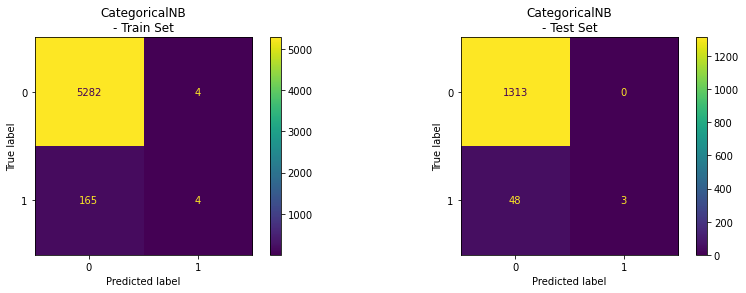

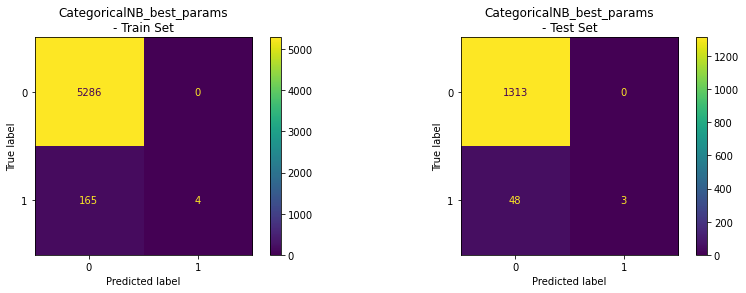

In [37]:
model_evaluation(X_train, X_test, y_train, y_test, 5, model_pipeline, model_names)
plot_confusion_matrix_2(X_train, X_test, y_train, y_test, model_pipeline, model_names)
print(best_params)

{'alpha': 0, 'fit_prior': True, 'min_categories': 2}

## Modeling with Scaling & Upsampling

In [42]:
X_train_scaled_mm, X_test_scaled_mm  = scale_features_mm(X_train, X_test)

In [43]:
smote = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=5)

X_train_final, y_train_final = smote.fit_resample(X_train_scaled_mm, y_train)
y_train_final.value_counts()

1    5286
0    5286
Name: Bankrupt?, dtype: int64

In [44]:
cat_nb_s_u = CategoricalNB(alpha=1, min_categories = 2)
cat_nb_s_u = cat_nb.fit(X_train_final, y_train_final)
param_grid = {
    'alpha': [0, 0.5, 1],
    # 'force_alpha': [False, True],
    'fit_prior' : [False, True],
    'min_categories': [0, 1, 2]
    }

grid_search = GridSearchCV(cat_nb_s_u, param_grid, cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_s_u = grid_search.best_params_
cat_nb_s_u_best= CategoricalNB(**best_params_s_u)
cat_nb_s_u_best.fit(X_train, y_train)

/Users/thaopham/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/thaopham/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thaopham/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/thaopham/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/thaopham/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weigh

CategoricalNB(alpha=0, min_categories=2)

In [45]:
model_pipeline_s_u = [cat_nb, cat_nb_s_u_best]
model_names_s_u = ['CatNB_scaled_upsampled', 'CatNB_scaled_upsampled_best']

CatNB_scaled_upsampled                     
                         Train Test Cross Val
0               Accuracy  0.50 0.96          
1              Precision  0.95 1.00          
2                 Recall  0.01 0.06          
3          Ave of Scores                 0.50
4          Std of Scores                 0.00

CatNB_scaled_upsampled_best                     
                              Train Test Cross Val
0                    Accuracy  0.50 0.96          
1                   Precision  1.00 1.00          
2                      Recall  0.01 0.06          
3               Ave of Scores                 0.50
4               Std of Scores                 0.00

{'alpha': 0, 'fit_prior': True, 'min_categories': 2}


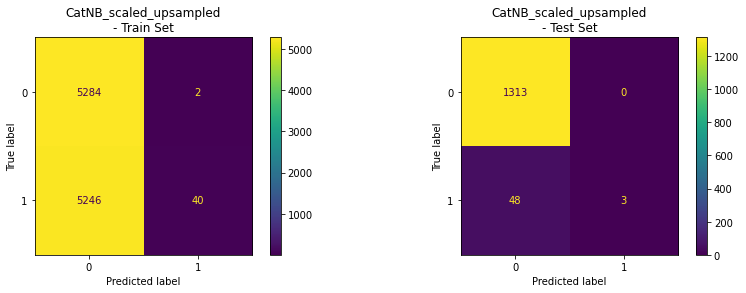

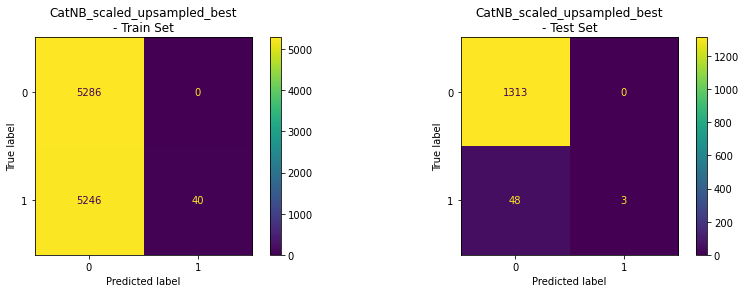

In [46]:
model_evaluation(X_train_final, X_test, y_train_final, y_test, 5, model_pipeline_s_u, model_names_s_u)
plot_confusion_matrix_2(X_train_final, X_test, y_train_final, y_test, model_pipeline_s_u, model_names_s_u)
print(best_params_s_u)

{'alpha': 0, 'fit_prior': True, 'min_categories': 2}

In [58]:
X_train_scaled, X_test_scaled  = scale_features(X_train, X_test)
smote = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=5)

X_train_final, y_train_final = smote.fit_resample(X_train_scaled, y_train)
y_train_final.value_counts()

1    5286
0    5286
Name: Bankrupt?, dtype: int64

In [59]:
quad_da = QuadraticDiscriminantAnalysis()
quad_da_org = quad_da.fit(X_train, y_train)

quad_da_s_u = QuadraticDiscriminantAnalysis()
quad_da_s_u = quad_da.fit(X_train_final, y_train_final)

QDA                     
                 Train Test Cross Val
0       Accuracy  0.96 0.95          
1      Precision  0.26 0.33          
2         Recall  0.21 0.31          
3  Ave of Scores                 0.96
4  Std of Scores                 0.00

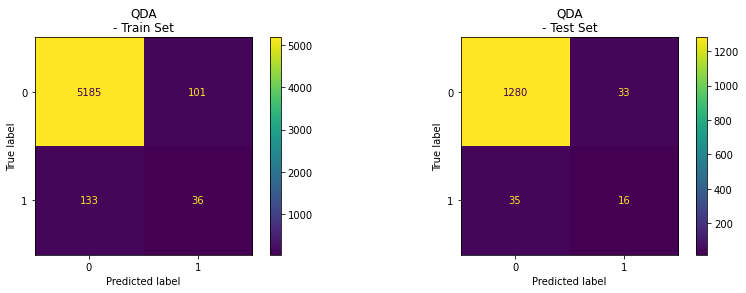

In [64]:
model_pipeline_qd = [quad_da]
model_names_qd = ['QDA']

model_evaluation(X_train, X_test, y_train, y_test, 5, model_pipeline_qd, model_names_qd)
plot_confusion_matrix_2(X_train, X_test, y_train, y_test, model_pipeline_qd, model_names_qd)

QDA Scaled & Upsampled                     
                         Train Test Cross Val
0               Accuracy  0.64 0.96          
1              Precision  0.93 0.00          
2                 Recall  0.31 0.00          
3          Ave of Scores                 0.65
4          Std of Scores                 0.02

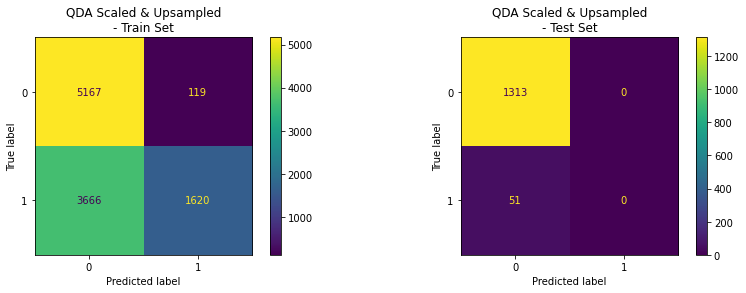

In [65]:
model_pipeline_qd = [quad_da_s_u]
model_names_qd = ['QDA Scaled & Upsampled']

model_evaluation(X_train_final, X_test, y_train_final, y_test, 5, model_pipeline_qd, model_names_qd)
plot_confusion_matrix_2(X_train_final, X_test, y_train_final, y_test, model_pipeline_qd, model_names_qd)